# Food 

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [7]:
torch.cuda.set_device(0)

In [8]:
PATH = "data/rakuten/"
sz = 224
arch = resnet34
bs = 64

In [9]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv))) - 1 # header is not counted (-1)
val_idxs = get_cv_idxs(n, val_pct=0.3) # random 20% data for validation set

In [10]:
n

554656

In [11]:
len(val_idxs)

166396

## Initial exploration

In [12]:
!ls {PATH}

class-mapping-num-jp-en.csv  sample_submission11.csv  tmp
labels.csv		     sample_submission.csv    train
readme.txt		     test


In [13]:
label_df = pd.read_csv(label_csv)

In [14]:
label_df.head()

,Image-Id,Category
0,1000000965.jpg,40
1,1310005493.jpg,31
2,1050002320.jpg,37
3,1340001721.jpg,33
4,1650001155.jpg,3


In [15]:
label_df.pivot_table(index="Category", aggfunc=len).sort_values('Image-Id', ascending=False)

,Image-Id
Category,
37,127135
33,43691
2,39805
3,37365
13,30485
5,30075
41,26826
28,26737
16,22084


In [16]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test', # we need to specify where the test set is if you want to submit to Kaggle competitions
                                   val_idxs=val_idxs, tfms=tfms, bs=bs)

In [17]:
fn = PATH + data.trn_ds.fnames[0]; fn

'data/rakuten/train/1000000965.jpg'

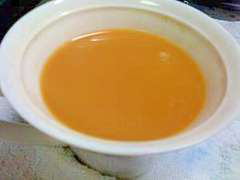

In [18]:
img = PIL.Image.open(fn); img

In [19]:
img.size

(240, 180)

In [20]:
size_d = {k: PIL.Image.open(PATH + k).size for k in data.trn_ds.fnames}

In [21]:
row_sz, col_sz = list(zip(*size_d.values()))

In [22]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

In [23]:
row_sz[:5]

array([240, 240, 240, 240, 240])

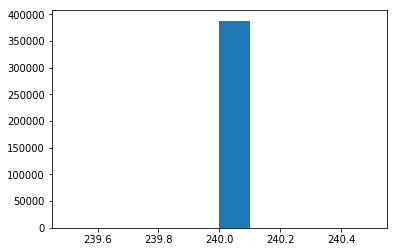

In [24]:
plt.hist(row_sz);

(array([     0.,      0.,      0.,      0.,      0., 388260.,      0.,      0.,      0.,      0.]),
 array([239.5, 239.6, 239.7, 239.8, 239.9, 240. , 240.1, 240.2, 240.3, 240.4, 240.5]),
 <a list of 10 Patch objects>)

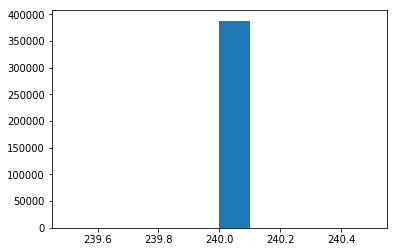

In [25]:
plt.hist(row_sz[row_sz < 1000])

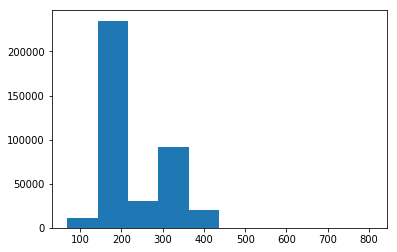

In [26]:
plt.hist(col_sz);

(array([ 10807., 234802.,  30731.,  92131.,  19710.,     68.,      8.,      1.,      1.,      1.]),
 array([ 69. , 142.7, 216.4, 290.1, 363.8, 437.5, 511.2, 584.9, 658.6, 732.3, 806. ]),
 <a list of 10 Patch objects>)

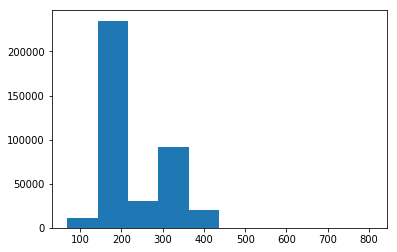

In [27]:
plt.hist(col_sz[col_sz < 1000])

In [28]:
len(data.trn_ds), len(data.test_ds)

(388260, 118863)

In [29]:
len(data.classes), data.classes[:5]

(43, ['0', '1', '10', '11', '12'])

## Initial model

In [30]:
def get_data(sz, bs): # sz: image size, bs: batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test',
                                       val_idxs=val_idxs, tfms=tfms, bs=bs)
    return data if sz > 300 else data.resize(340, 'tmp')

### Precompute

In [31]:
data = get_data(sz, bs)

In [32]:
learn = ConvLearner.pretrained(arch, data)

In [33]:
learn.precompute=False
learn.unfreeze()

In [34]:
learn.load('oshoafterunfreezemlr48.9')

In [32]:
learn.fit(1e-3,1)

epoch      trn_loss   val_loss   accuracy                       
    0      1.855076   1.790912   0.50223   



[array([1.79091]), 0.5022296209043486]

In [35]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.49539051419505276, 1.8169659036105774)

In [36]:
len(data.val_ds.y), data.val_ds.y[:5]

(166396, array([31, 19, 27,  1, 15]))

In [37]:
learn.save('final')

In [38]:
learn.load('final')

## Create submission and evaluation script

In [39]:
data.classes

['0',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '40',
 '41',
 '42',
 '5',
 '6',
 '7',
 '8',
 '9']

In [40]:
data.test_ds.fnames

['test/1600000909.jpg',
 'test/1150004177.jpg',
 'test/1510003362.jpg',
 'test/1700013520.jpg',
 'test/1170010138.jpg',
 'test/1350005491.jpg',
 'test/1760019354.jpg',
 'test/1200003488.jpg',
 'test/1130003096.jpg',
 'test/1640012108.jpg',
 'test/1090006536.jpg',
 'test/1240021308.jpg',
 'test/1150008810.jpg',
 'test/1750024828.jpg',
 'test/1450009431.jpg',
 'test/1390012050.jpg',
 'test/1070030094.jpg',
 'test/1070015134.jpg',
 'test/1560002497.jpg',
 'test/1590006935.jpg',
 'test/1330000700.jpg',
 'test/1610001199.jpg',
 'test/1370000189.jpg',
 'test/1100009915.jpg',
 'test/1320000665.jpg',
 'test/1450012465.jpg',
 'test/1390011572.jpg',
 'test/1730009730.jpg',
 'test/1420000053.jpg',
 'test/1610003522.jpg',
 'test/1460002381.jpg',
 'test/1020005964.jpg',
 'test/1150008479.jpg',
 'test/1420004655.jpg',
 'test/1140007964.jpg',
 'test/1540004279.jpg',
 'test/1030004753.jpg',
 'test/1290006605.jpg',
 'test/1750020411.jpg',
 'test/1350006451.jpg',
 'test/1400002687.jpg',
 'test/141000220

In [41]:
log_preds, y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds),0)

In [42]:
probs.shape # (n_images, n_classes)

(118863, 43)

In [43]:
df = pd.DataFrame(probs)
df.columns = data.classes
df1=df

In [44]:
df.head()

,0,1,10,11,12,13,14,15,16,17,...,39,4,40,41,42,5,6,7,8,9
0,0.000501,0.004224,0.003436,0.011018,0.271065,0.001069,0.001435,0.007199,0.031805,0.005179,...,0.008196,0.002454,0.000129,0.031801,0.290178,0.051296,0.000209,0.003296,0.002875,0.001420
1,0.007459,0.001853,0.000538,0.004163,0.000119,0.000032,0.000043,0.000199,0.003641,0.000571,...,0.000315,0.000569,0.000150,0.006670,0.001138,0.015313,0.000045,0.000047,0.000035,0.000241
2,0.001583,0.007562,0.002168,0.003195,0.000078,0.000182,0.000478,0.000325,0.057323,0.000443,...,0.000344,0.002074,0.000031,0.003855,0.000013,0.025547,0.000010,0.000027,0.000042,0.000087
3,0.005293,0.009569,0.000467,0.008086,0.000303,0.022228,0.000201,0.008799,0.048077,0.003686,...,0.000950,0.011557,0.000290,0.237541,0.001274,0.081170,0.000089,0.000190,0.000435,0.002206
4,0.000158,0.008981,0.001548,0.001904,0.000354,0.866385,0.000125,0.000749,0.004265,0.004217,...,0.000223,0.001347,0.000081,0.014167,0.004436,0.008661,0.000057,0.001388,0.000441,0.000227


In [45]:
df.insert(0, 'Image-Id', [o[5:-4] for o in data.test_ds.fnames])

In [46]:
df.head()

,Image-Id,0,1,10,11,12,13,14,15,16,...,39,4,40,41,42,5,6,7,8,9
0,1600000909,0.000501,0.004224,0.003436,0.011018,0.271065,0.001069,0.001435,0.007199,0.031805,...,0.008196,0.002454,0.000129,0.031801,0.290178,0.051296,0.000209,0.003296,0.002875,0.001420
1,1150004177,0.007459,0.001853,0.000538,0.004163,0.000119,0.000032,0.000043,0.000199,0.003641,...,0.000315,0.000569,0.000150,0.006670,0.001138,0.015313,0.000045,0.000047,0.000035,0.000241
2,1510003362,0.001583,0.007562,0.002168,0.003195,0.000078,0.000182,0.000478,0.000325,0.057323,...,0.000344,0.002074,0.000031,0.003855,0.000013,0.025547,0.000010,0.000027,0.000042,0.000087
3,1700013520,0.005293,0.009569,0.000467,0.008086,0.000303,0.022228,0.000201,0.008799,0.048077,...,0.000950,0.011557,0.000290,0.237541,0.001274,0.081170,0.000089,0.000190,0.000435,0.002206
4,1170010138,0.000158,0.008981,0.001548,0.001904,0.000354,0.866385,0.000125,0.000749,0.004265,...,0.000223,0.001347,0.000081,0.014167,0.004436,0.008661,0.000057,0.001388,0.000441,0.000227


In [47]:
df = df.set_index('Image-Id').apply(lambda x: pd.Series(x.sort_values(ascending=False)
       .iloc[:3].index, 
      index=['top1','top2','top3']), axis=1).reset_index()
df.head()

,Image-Id,top1,top2,top3
0,1600000909,42,12,37
1,1150004177,28,37,5
2,1510003362,37,16,5
3,1700013520,41,37,33
4,1170010138,13,37,33


In [49]:
df["Category"]=df["top1"]+","+df["top2"]+","+df["top3"]

In [50]:
df=df[["Image-Id","Category"]]

In [52]:
print(df)

          Image-Id  Category
0       1600000909  42,12,37
1       1150004177   28,37,5
2       1510003362   37,16,5
3       1700013520  41,37,33
4       1170010138  13,37,33
5       1350005491  33,37,41
6       1760019354   33,37,1
7       1200003488    2,13,5
8       1130003096  33,41,37
9       1640012108   37,22,5
10      1090006536    5,37,2
11      1240021308   37,16,2
12      1150008810   11,2,40
13      1750024828  28,37,22
14      1450009431    37,5,3
15      1390012050  37,33,22
16      1070030094   37,5,10
17      1070015134     3,1,5
18      1560002497   13,36,2
19      1590006935   2,28,40
20      1330000700   37,42,3
21      1610001199   37,13,2
22      1370000189   37,10,5
23      1100009915   37,5,22
24      1320000665   40,11,2
25      1450012465   22,13,2
26      1390011572   37,5,16
27      1730009730  12,42,37
28      1420000053   11,2,37
29      1610003522   5,37,33
...            ...       ...
118833  1260005389   37,16,5
118834  1330004229    2,13,5
118835  101001

In [54]:
df

,Image-Id,Category
0,1600000909,"42,12,37"
1,1150004177,"28,37,5"
2,1510003362,"37,16,5"
3,1700013520,"41,37,33"
4,1170010138,"13,37,33"
5,1350005491,"33,37,41"
6,1760019354,"33,37,1"
7,1200003488,"2,13,5"
8,1130003096,"33,41,37"
9,1640012108,"37,22,5"


In [55]:
df["Image-Id"]=df["Image-Id"]+".jpg"

In [56]:
df

,Image-Id,Category
0,1600000909.jpg,"42,12,37"
1,1150004177.jpg,"28,37,5"
2,1510003362.jpg,"37,16,5"
3,1700013520.jpg,"41,37,33"
4,1170010138.jpg,"13,37,33"
5,1350005491.jpg,"33,37,41"
6,1760019354.jpg,"33,37,1"
7,1200003488.jpg,"2,13,5"
8,1130003096.jpg,"33,41,37"
9,1640012108.jpg,"37,22,5"


In [57]:
df.to_csv("Final_submission.csv",index=False)